In [1]:
!pip install uv
!uv pip install -r requirements.txt
!./install_circuitsvis.sh
# please install yarn as per README.md


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Using Python 3.11.9 environment at: venv
Audited 9 packages in 9ms
Using Python 3.11.9 environment at: venv
Audited 1 package in 2ms


In [2]:
%load_ext autoreload
%autoreload 2
import torch
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration
from PIL import Image
import matplotlib.pyplot as plt

torch.set_grad_enabled(False)  # avoid blowing up mem
device = "cuda"

In [3]:
model_id = "google/paligemma2-3b-pt-224"
model = (
    PaliGemmaForConditionalGeneration.from_pretrained(
        model_id, torch_dtype=torch.bfloat16
    )
    .to(device)
    .eval()
)
processor = PaliGemmaProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

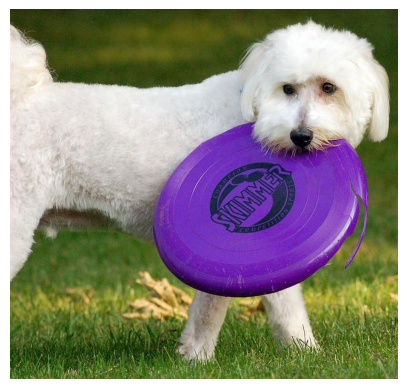

In [4]:
img_path = "imgs/frisbee.jpg"
image = Image.open(img_path)
plt.axis("off")
_ = plt.imshow(image)

In [5]:
from getAttentionLib import (
    get_response,
    dump_attn,
    get_img_grid_sizes,
    plot_mult_attn_sums,
)

text = "<image>Answer en what color is the frisbee?"
inputs_tokens, response = get_response(model, processor, text, image)
print(inputs_tokens)
print(response)

The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


['<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>'

# Create Multimodal Attention Visualization

In [6]:
inputs = processor(text=text, images=image, return_tensors="pt").to(model.device)
n_img_tokens, grid_side_len = get_img_grid_sizes(model, inputs)
attentions = torch.stack(model(**inputs, output_attentions=True).attentions).float()
for layer_idx in [0, 15, 25]:
    # print(state.outputs.shape, state.attn_weights.shape, inputs.input_ids.shape)
    dump_attn(
        attn_weights=attentions[layer_idx],
        layer_idx=layer_idx,
        name="PaliGemma2",
        tokens=inputs_tokens,
        img_path=img_path,
        grid_side_len=grid_side_len,
    )

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.


Rendered HTML
Wrote to file='PaliGemma2_layer_0_attention_heads.html'
Rendered HTML
Wrote to file='PaliGemma2_layer_15_attention_heads.html'
Rendered HTML
Wrote to file='PaliGemma2_layer_25_attention_heads.html'


# Plot Region-wise Attention

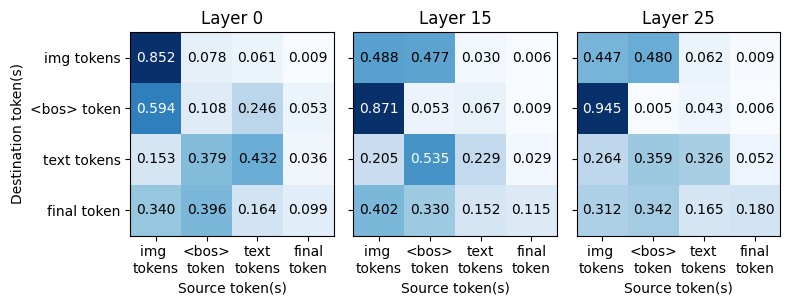

In [7]:
fig = plot_mult_attn_sums(model, inputs, layers=[0, 15, 25])
fig.savefig("imgs/blockwise-attn-sums-frisbee.png")
fig.show()

The plot below is the same as the one above, but it shows the progression of attention for every layer. The left plot are the img tokens, which are attending mostly to other image tokens and to the <bos> token. The middle plot is the <bos> token, which is attending almost exlusively to the image tokens. The right plot is the text tokens, which show no obvious pattern. Nevertheless, they attend to the <bos> token as much as they attend to all image tokens, or text tokens combined.

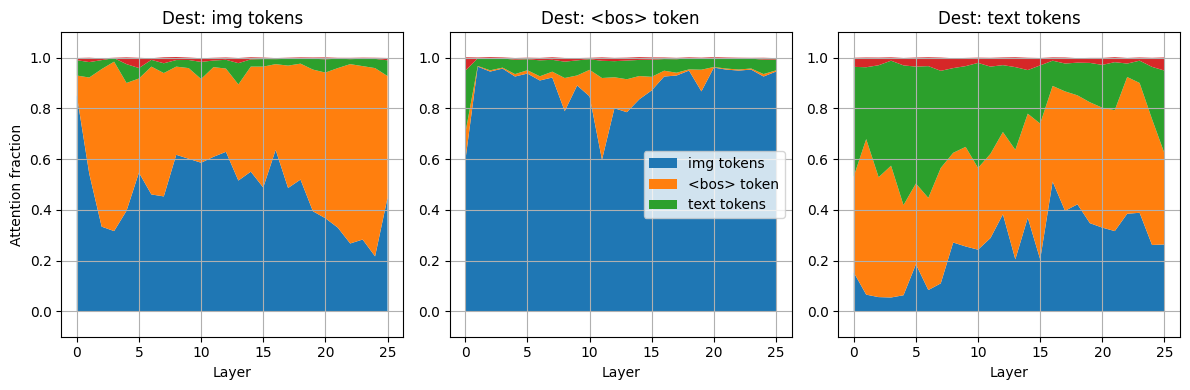

In [8]:
from getAttentionLib import plot_region_attn_progression

fig = plot_region_attn_progression(model, inputs)
fig.show()

# Verify Numbers on VQA

In [9]:
from getAttentionLib import compute_mult_attn_sums_over_vqa, plot_images_grid

layers = [0, 15, 25]
n_vqa_samples = 100
stacked_attens, imgs, responses = compute_mult_attn_sums_over_vqa(
    model, processor, n_vqa_samples=n_vqa_samples, layers=layers
)

Repo card metadata block was not found. Setting CardData to empty.
 61%|██████    | 61/100 [00:10<00:05,  7.62it/s]

Unsupported number of image dimensions: 2


100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


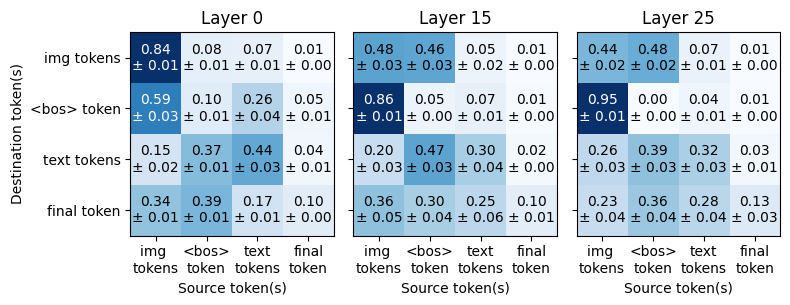

In [10]:
means = stacked_attens.mean(dim=0)
assert means.shape == (len(layers), 4, 4)
stds = stacked_attens.std(dim=0)
assert stds.shape == (len(layers), 4, 4)
fig = plot_mult_attn_sums(None, None, layers=layers, mult_attn_sums=means, stds=stds)
fig.savefig(f"imgs/blockwise-attn-sums-vqa{n_vqa_samples}.png")
fig.show()

# Show VQA Grid

In [11]:
import textwrap


def process_response(r: str) -> str:
    q, a = r.split("\n")
    chars_per_line = 20
    # Wrap text to fit within subplot
    q = textwrap.fill(q, width=chars_per_line)
    return f"Q: {q}\nA: {a}"


process_response(responses[0])

'Q: Answer en What is\nthis photo taken\nlooking through?\nA: net'

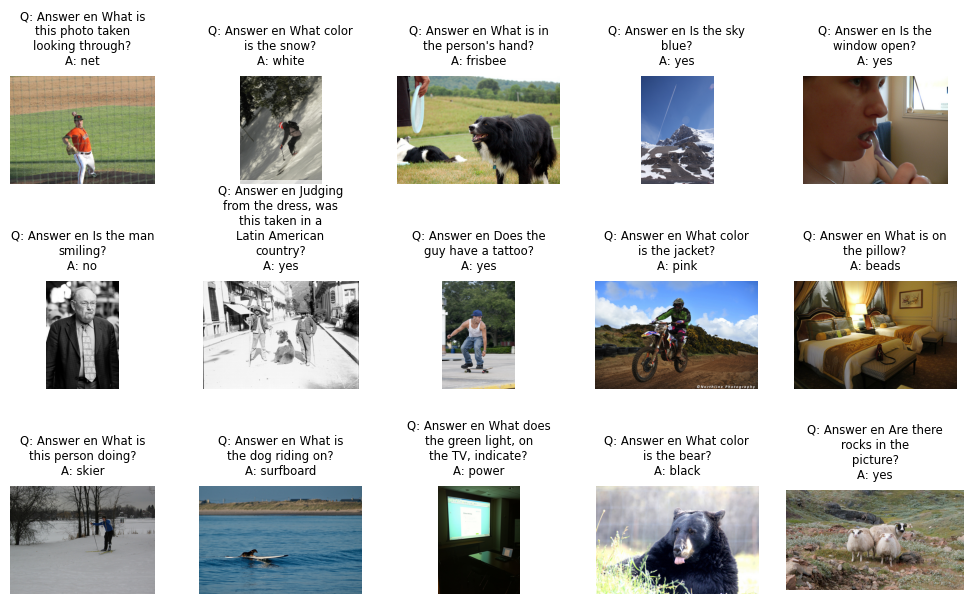

In [12]:
proc_responses = [process_response(r) for r in responses]
fig = plot_images_grid(
    imgs[:15], proc_responses[:15], nrows=3, ncols=5, figsize=(10, 6)
)
fig.savefig("imgs/vqa-grid-of-img-question-answer.png")
fig.show()